# Web scraping
## An introduction using Beautiful Soup

This lesson will introduce you to the world of web scraping and show you how one library, Beautiful Soup, allows you to gather large amounts of data from all sorts of web pages. Basic HTML structure will also be introduced and you will learn how to navigate its tree structure. 
 

**Difficulty:** Intermediate

**Completion Time:** 45 Minutes

**Knowledge Required:** Python basics (variables, data types, functions, loops, list comprehensions), Pandas basics

**Knowledge Recommended:** HTML/webpage structure basic knowledge

**Learning Objectives:** After this lesson you will be able to:
1. Understand and implement web scraping using BeautifulSoup.
2. Identify and navigate HTML tree structure to isolate desired nodes.
3. Build the first steps of a text analysis pipeline.
4. Be aware of other resources and methods for web scraping.

**Research Pipeline:** 
1. Choose your resources - website(s) and volume of desired content
2. Use the skills in this lesson to obtain the data and turn it into a user-friendly dataframe 
3. Transform the data as best fits your project goals - once it is in a data frame, many things are possible!

**Libraries Used:** 
- [Pandas](https://pandas.pydata.org) _For manipulating and organizing data_
- [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/) _For web scraping_   
- [Requests](https://pypi.org/project/requests/) _For accessing webpages_   
- [Urllib](https://pypi.org/project/urllib3/) _As an HTTP client_

## Introduction

**What is web scraping?**
- Web scraping refers to the process of extracting content (data) from a webpage using some form of software (bot, web crawler). 
- Utilizes the structure of web pages (which are built using HTML or XHTML, a text-based mark-up language) to extract the data you want.

**Why should I learn web scraping?**
- While there are many pre-compiled datasets out there, many projects require specific data that is not readily available. Being able to gather the precise data you want for your project is a huge advantage.
- Web scraping allows you to harvest very large amounts of data with ease.

**How do I learn web scraping?**
- There are many methods for web scraping, with some being more optimized for obtaining certain information. You can build your own, as we do in this lesson with Beautiful Soup, which allows you to obtain very specific data but must be modified for different sources. There is also pre-built software you can download, which can require little to no coding. This can be a browser extension or software run through the command line or a user interface. 
- In this lesson we will focus on one particular method, but it is by no means the only option out there. 

**Wait, is web scraping legal?**
- Gathering all this data feels almost too good to be true, is it? 
- Short answer: web scraping is legal!
- Longer answer: every site is different and has different copyright rules. Always check before scraping and especially before publishing or redistributing any scraped information. For instance, many news sites have rules against reproducing their work - so you can scrape and analyze all you want but you cannot publish or show whole articles for free. 

## HTML, a brief overview

Before we get into web scraping we first need to understand what goes on behind the scenes of a webpage. Webpages are built from HTML or XHTML, which is a text based markup language. There is a hierarchy to HTML and once you understand how it works traversing it to find the information you need becomes simple.

### The hierarchy

The structure of HTML is often referred to as a tree because it is made up of one root element with any number of branching descendant nodes. For instance, a root `<html>` node must have two children, a `<head>` node and a `<body>` node; each of which contains its own children and their children. Therefore, the node directly below another in the tree structure is a child node while the entirety of its children and its childrens children are descendants of that node. Children can also have parents (the node above them) and siblings (those nodes on the same level as them). Thinking of it in these familial terms can make it more intuitive. Below is an image that illustrates this tree structure: 

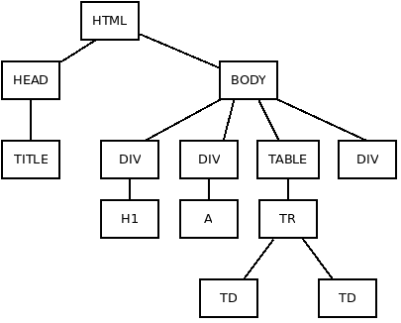

Simply put, elements are pairs of tags which tell the browser what information is stored between them and how to display it. For instance, `<p>` elements are used to contain paragraphs (textual data) and `<a>` elements contain links. There are many kinds of tags, but for our purposes most of the information we are looking for will be in `<p>`, `<a>` or `<span>` tags, which are typically children of `<div>` tags. You may notice that there are also words like `class` or `id` within these tags that have their own values. These may look confusing at first, but they are very helpful in helping to point to the exact node you want. 

### Finding the information you need

But how do you go about finding the node you need? In order to do this you need to do a bit of digging and leg work. To view this underlying structure you can navigate to the webpage you wish to scrape and just `right click` and then choose 'Inspect' or 'Inspect Element'. This will pull up a side or bottom panel that provides an interactive view of the underlying HTML. There is often an overwelming number of tags so it can be helpful to highlight a word in the main text you wish to obtain and then hitting `right click` as this will take you directly to that location in the hierarchy. From here you can see the name of the element that contains the information you want along with its parent, which is the information you will need for scraping. 

In [1]:
# Import libraries
import pandas as pd
from bs4 import BeautifulSoup
import requests
import urllib

## Scraping: Getting Started

In this lesson we are going to scrape the Pitt News website and gather the articles that are currently on the home page. You can visit their website [here](https://pittnews.com/). We are going to begin by navigating to the home page and collecting all the links to the articles that exist there. 

In [2]:
# Storing the URL in a variable
baseUrl = 'https://pittnews.com/'

# Initialize an empty list for the links
hrefList = []

# Call the base URL, turn it into soup then find all parents of link elements, 
##  drill down to the children and append each link to the list
response = requests.get(baseUrl)
soup = BeautifulSoup(response.text, 'html.parser')
divs = soup.find_all('div', {'class':'sno-story-card-link'})
for div in divs:
    a = div.find('a')
    hrefList.append(a.get('href'))

In [3]:
# Check that it did what we think
print(len(hrefList))
print(hrefList[0])

52
https://pittnews.com/article/175690/news/a-special-time-pitt-alumni-reflect-on-homecoming-traditions-throughout-history/


### Scraping: Gathering Data

This chunk of code is a little more dense, so here is a brief explanation. Three empty dictionaries are initialized, one for the title of each article, one for the date it was published and one for the text of the article. Then we loop through each link from the list created above and open and collect the html from each page. This is turned to soup and from there each element we need is found and turned to text; which is then added as the value to its respective dictionary with the link to the article as the key. Using the links as keys allows us to utilize a very useful function later on when we are building the data frame. 

In [4]:
# get text and other details from articles
titleDict = {}
dateDict = {}
textDict = {}

for href in hrefList:
    response = requests.get(href)
    soup = BeautifulSoup(response.text, 'html.parser')
    try:
        # Get the date/time for each article
        date = soup.find('span', {'class':'time-wrapper'}).text
        dateDict[href] = date
        
        # Get the text for each article
        content = soup.find('span', {'class':'storycontent'})
        paras = content.find_all('p')
        text = [t.text for t in paras]
        textDict[href] = text
        
        # Get the title of each article
        title = soup.find('h1', {'class':'storyheadline'}).text
        titleDict[href] = title
    except:
        print('There is an error with this link')  # So we know if there is an issue with a link
        pass

In [5]:
# Checking our collected data
# Turning it into a list first because dictionaries are not iterable

titleList = list(titleDict.items())
print(titleList[0])

dateList = list(dateDict.items()) 
print(dateList[0])

textList = list(textDict.items())
print([t[:3] for t in textList[12]])

('https://pittnews.com/article/175690/news/a-special-time-pitt-alumni-reflect-on-homecoming-traditions-throughout-history/', '‘A special time’: Pitt alumni reflect on homecoming traditions throughout history')
('https://pittnews.com/article/175690/news/a-special-time-pitt-alumni-reflect-on-homecoming-traditions-throughout-history/', ' 12:54 am')
['htt', ['I’m pretty sure the 11 words that undoubtedly produce the most happiness are, “It’s time to get things started on The Muppet Show tonight.”\xa0', 'The Muppets have made audiences chuckle, snort and cackle with their skits, songs and interactions for the past 50 years, and fans will continue to adore them for generations to come. ', 'The Muppets — Jim Henson’s brainchild — began their stardom in a television show created in 1976, eventually expanding into multiple movies, a modernized television show and even an experience in Disney World. For those who have been living under a rock, the Muppets are puppets maneuvered by humans off the

### Scraping: Cleaning the Data

Now that we have the data we want and have taken a quick look at it we are can there are a few things that need to be taken care of before the data is ready to be stored in a more final form. Firstly there are some strange special characters in the text (`\xa0`) which we want to remove. You may also have noticed that the text data is a list of strings, not one cohesive string. These strings should be joined into one before we move forward. 

This data is fairly clean, however this part of the data scraping pipeline can vary depending on the state of your data and the goal of your analysis. 

In [6]:
# Getting rid of the special character
for k,v in textDict.items():
    vrep = [x.replace('\xa0', '') for x in v]
    textDict[k] = vrep

# Joining the sentences 
textListCleaned = [' '.join(v) for k,v in textDict.items()]

### Scraping: Storing the Data

Now that the data is cleaned it can go in a data frame for futher manipulation or storage - whatever your project requires! 

In [7]:
# Title dictionary to dataframe
pittNewsDF = pd.DataFrame.from_dict(titleDict, orient='index')

# Reset the index so it is not the hrefs
pittNewsDF.reset_index(inplace=True)

# Name the columns
pittNewsDF.columns = ['Href', 'Title']

# Add our other dictionaries to the data frame using zip()
pittNewsDF['Date/Time'] = pittNewsDF['Href'].map(dateDict)
pittNewsDF['Text'] = textListCleaned

# Take a look
pittNewsDF.head()

,Href,Title,Date/Time,Text
0,https://pittnews.com/article/175690/news/a-spe...,‘A special time’: Pitt alumni reflect on homec...,12:54 am,"For Valerie Njie, Pitt’s homecoming celebratio..."
1,https://pittnews.com/article/175699/sports/spo...,Take 5 | Pickett should start for Steelers mov...,9:46 am,"In this week’s edition of Take 5, The Pitt New..."
2,https://pittnews.com/article/175697/top-storie...,"Behind talented additions, Pitt men’s basketba...",9:37 am,For the first time in seemingly forever for Pi...
3,https://pittnews.com/article/175694/news/sgb-p...,SGB promotes mental health awareness at weekly...,1:38 am,President Danielle Floyd opened Student Govern...
4,https://pittnews.com/article/175688/opinions/o...,"Opinion | Even if football isn’t your thing, y...",12:42 am,I’m just gonna say it — I don’t like football....


In [8]:
pittNewsDF['Text'].loc[1]

'In this week’s edition of Take 5, The Pitt News sports desk takes a look at the NFL’s ineffective concussion protocol, Steelers and former Pitt quarterback Kenny Pickett’s NFL debut and more. Despite ugly start, Kenny Pickett is the guy // Jermaine Sykes, Staff Writer The Steelers finally benched quarterback Mitch Trubisky in favor of first-round draft pick Kenny Pickett in Sunday’s 24-20 loss against the Jets. Pickett showed flashes of brilliance for a team that desperately needs to recalibrate after an unusual 1-3 start. Head coach Mike Tomlin put Pickett into the game because the Steelers “needed a spark.” A spark might be a stretch, but Pickett’s arrival did invigorate the crowd, receiving loud ovations. The fans stayed loud until his first pass attempt, which former Pitt safety Jordan Whitehead intercepted. Pickett finished the game completing 10 of 13 passes for 120 yards. The Jets intercepted all three incompletions. Despite the turnovers, Pickett showed willingness to take sho

In [9]:
# Taking a quick look at the data frame
pittNewsDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Href       38 non-null     object
 1   Title      38 non-null     object
 2   Date/Time  38 non-null     object
 3   Text       38 non-null     object
dtypes: object(4)
memory usage: 1.3+ KB


## Caveats and Future Directions

Congratulations! You now know the basics of web scraping and the mechanics of one scraping library. Armed with this knowledge, and perhaps a little documentation study, you are ready to tackle any website you wish and gather whatever data you need. However, before we get too carried away it is important to note that while Beautiful Soup is powerful there are some things it is not equipped to handle. 

**The Caveats**
- Beautiful Soup cannot handle JavaScript.
- It has to be tweaked for every new website, which does require some hands on work initially.
- Depends on having a parser and a library to send requests.
- Can be laggy and bad for huge quantities of data.
- Doesn't have good proxy support, so your IP address could be flagged.

**Some Other Options**

Since Beautiful Soup cannot handle everything (and maybe it is just not your favorite web scraping method) here are some other options that you might want to look into:
- [Selenium](https://www.selenium.dev): is a popular method that is able to handle JavaScript and AJAX requests and is very beginner friendly.
- [Scrapy](https://scrapy.org): an open source framework that is excellent at handling proxies and building pipelines for very large quantities of data. 

**Some Useful Resources**

- [Beautiful Soup Documentation](https://www.crummy.com/software/BeautifulSoup/bs4/doc/)
- [A useful article about choosing a scraping method](https://medium.com/analytics-vidhya/scrapy-vs-selenium-vs-beautiful-soup-for-web-scraping-24008b6c87b8)
- [HTML Basics](http://dh.obdurodon.org/html_basics.xhtml)